In [1]:
def tpar_boundary_noaa_forecast_AU(controle, paths_input,paths_output, forecast_time):
    import numpy as np
    import matplotlib.pyplot as plt
    import xarray as xr
    import os, glob
    #import Nio
    from scipy.io import loadmat
    import pandas as pd 
    import seaborn as sns
    import datetime
    import cfgrib
    
    ## Descricao 
    
    # - controle = True para especificar que vc quer gerar condicao de fronteira de controle
    # - controle = False para especificar que vc quer gerar condicao de fronteira dos membros
    # - paths_input = local onde os dados de NOAA/WW3 ENSEMBLE estao aramazenados 
    # - paths_output = local onde deseja aramzenar os dados
    # - datetime = inicio do periodo da simulacao 
    
    # Colocar a funcao de selecionar os pontos das condicoes de fronteira

    ## Escrevento as condicoes de contorno de onda

    # funcao para escrever as coordenadas

    def coord_points(vert1, vert2, resolution):
        import numpy as np
    
        # Create matrix of linear equation ax + b = y from vertices
        a = np.array([[vert1[0], 1], [vert2[0], 1]])
        b = np.array([vert1[1], vert2[1]])
    
        #Calculate a and b
        a, b = np.linalg.solve(a, b)
    
        # Create list of x coords between vertices
        x_coords = np.arange(vert1[0], vert2[0], resolution).tolist()
        y_coords = []
    
        # Calculate y coords from x coords
        for coord in x_coords:
            y = (a*coord) + b
            y_coords.append(y)
        coords = np.column_stack((x_coords, y_coords))
        return coords

    # Coordenadas para a grade no suldeste Australiano

    vert_NW = [151.65003543, -33.1295192]
    vert_NE = [152.65390148, -33.59930308]
    vert_SW = [150.13428217, -36.17691697]
    vert_SE = [151.04435391, -36.62430852]

    coords_north = coord_points(vert_NW, vert_NE, 0.25)
    coords_east = coord_points(vert_SE, vert_NE, 0.25).tolist()
    coords_east.sort(reverse = True)
    coords_east = np.array(coords_east)
    coords_south = coord_points(vert_SW,vert_SE, 0.25).tolist()
    coords_south.sort(reverse = True)
    coords_south = np.array(coords_south)
    coords = np.vstack((coords_north, coords_east, coords_south))
    print(len(coords))
    
    # Montando Tempo 
    
    n = 105

    time_0 = forecast_time 
    time = pd.date_range(time_0, periods=n, freq='3H')
    time_forecast = time.format(formatter=lambda x: x.strftime('%Y%m%d.%H%M'))
    
    

    
    if controle:
        
        # set paths to controle forecast
        #os.chdir(paths_input)
        #fl = sorted(glob.glob(os.path.join('ww3_c_forecast_'+str(datetime)+'_f*.grb2')))
        #contr = xr.concat((xr.open_dataset(file, engine = 'pynio') for file in fl),dim = 'time')
        
        #paths_input= '/Volumes/Benitez/buoy_AU/noaa_forecast/noaa_wave_ensemble/ensemble_2021_08_27/wave_c_'
        paths_input= paths_input+'/wave_c_'
        time_paths = []
        time_p = time[0]
        
        nn=4
    
        for i in range(0,nn):
            a = time_p + datetime.timedelta(i)
            b = a.strftime('%Y%m%d')
            time_paths.append(paths_input+b)
        
        # Controle

        contro = {}
        prev_forecast = []

        for t in range(0,nn):
            os.chdir(time_paths[t])
            if t < nn-1:
                prev_fore = sorted(glob.glob(os.path.join('ww3_c_forecast_*.grb2')))[:8]
                contro["contr"+str(t)] = xr.concat((xr.open_dataset(file, engine = 'cfgrib') for file in prev_fore),dim = 'time')
            else:
                prev_fore = sorted(glob.glob(os.path.join('ww3_c_forecast_*.grb2')))
                contro["contr"+str(t)] = xr.concat((xr.open_dataset(file, engine = 'cfgrib') for file in prev_fore),dim = 'time')

        contr = xr.concat((contro['contr'+str(j)] for j in range(0,nn)), dim='time')       
        
        
    
        bounds_controle=[]
    
        for p in range(len(coords)):
            bound_c=contr.sel(dict(longitude=(coords[p][0]),latitude=coords[p][1]),method='nearest')
            bounds_controle.append(bound_c)
        
        # Control

        hs_controle = xr.concat(bounds_controle,"bound_numbers").swh.values
        tp_controle = xr.concat(bounds_controle,"bound_numbers").perpw.values
        dm_controle = xr.concat(bounds_controle,"bound_numbers").dirpw.values
        spr = np.ones([len(time_forecast),1])*4 # O valor 4 e usando para spread quando não esta disponivel
        
        plt.plot(hs_controle[8])
    
    # Criando fronteira para controle


        os.chdir(paths_output)
        os.makedirs('boundary_' + str(forecast_time) + '_controle')
        os.chdir(paths_output + '/boundary_' + str(forecast_time) + '_controle')
        for i in range(len(coords)):
            f = open("tpar_forecast_c_" + str(i) + ".bnd", "w")
            f.write("TPAR")
            f.write('''
''')
            TPAR = np.transpose(np.vstack((time_forecast,hs_controle[i,:],tp_controle[i,:],dm_controle[i,:],spr[:,0])))
            f.write(pd.DataFrame(TPAR).to_string(index=False,
                                                        header=False,
                                                        float_format='%10.5f'))
            f = open("tpar_forecast_c_" + str(i) + ".bnd","rt")
            data = f.read()
            data = data.replace(" 2021", "2021")
    
    
            f = open("tpar_forecast_c_" + str(i) + ".bnd","wt")
            f.write(data)
            f.close()
    
        f.close()
    
    
    else:
        
        #os.chdir(paths_input)
        #fl = sorted(glob.glob(os.path.join('ww3_*.grb2')))
        #pr1 = xr.concat((xr.open_dataset(file, engine = 'pynio') for file in fl),dim = 'time')
        
        paths_input= paths_input+'/wave_p_'
        time_paths = []
        time_p = time[0]
        
        nn=4
    
        for i in range(0,nn):
            a = time_p + datetime.timedelta(i)
            b = a.strftime('%Y%m%d')
            time_paths.append(paths_input+b)
        
        ##
            
        membros = {}
        prev_forecast = []
        me = []
        mem={}
        membros_fore={}
        memm = {}

        for t in range(0,nn):
            os.chdir(time_paths[t])
            if t < nn-1:
                for k in range(1,31):
                    prev_fore = sorted(glob.glob(os.path.join('ww3_'+str(k).zfill(2)+'*.grb2')))[:8]
                    membros["m"+str(k)] = xr.concat((xr.open_dataset(file, engine = 'cfgrib') for file in prev_fore),dim = 'time_0')
                    mem['membro'+str(t)]=xr.concat((membros[m] for m in membros), dim='membros')
            
                membros_forecast = xr.concat((mem[p]  for p in mem), dim='time_0')
    
            else:
                for n in range(0, 2430, 81):
                    prev_fore = sorted(glob.glob(os.path.join('ww3_*.grb2')))[n:n+81]
                    membros_fore['m'+str(n)] = xr.concat((xr.open_dataset(file, engine = 'cfgrib') for file in prev_fore),dim = 'time_0')
                memm = xr.concat((membros_fore[x] for x in membros_fore), dim='membros')

        pr1 = xr.concat((membros_forecast, memm), dim='time_0') 
            
                
        ##

        bounds_members=[]
        for p in range(len(coords)):
            bound_m=pr1.sel(dict(longitude=(coords[p][0]),latitude=coords[p][1]),method='nearest')
            bounds_members.append(bound_m)
            
        # Members

        hs_fore = xr.concat(bounds_members,"bound_numbers").swh.values
        tp_fore = xr.concat(bounds_members,"bound_numbers").perpw.values
        dm_fore = xr.concat(bounds_members,"bound_numbers").dirpw.values
        spr = np.ones([len(time_forecast),1])*4 # O valor 4 e usando para spread quando não esta disponivel
        
        
        
        # Criando fronteira para cada membros

        for j in range(30):
            os.chdir(paths_output)
            os.makedirs('boundary_' + str(forecast_time) + '_members_' + str(j))
            os.chdir(paths_output + '/boundary_' + str(forecast_time) + '_members_' + str(j))
            for i in range(len(coords)):
                f = open("tpar_forecast_" + "p" +str(j) + "_" + str(i) + ".bnd", "w")
                f.write("TPAR")
                f.write('''
''')
                TPAR = np.transpose(np.vstack((time_forecast,hs_fore[i,j,:],tp_fore[i,j,:],dm_fore[i,j,:],spr[:,0])))
                f.write(pd.DataFrame(TPAR).to_string(index=False,
                                                           header=False,
                                                           float_format='%10.5f'))
                f = open("tpar_forecast_" + "p" +str(j) + "_" + str(i) + ".bnd","rt")
                data = f.read()
                data = data.replace(" 2021", "2021")
    
    
                f = open("tpar_forecast_" + "p" +str(j) + "_" + str(i) + ".bnd","wt")
                f.write(data)
                f.close()
    
            f.close()
        
        sns.set_style("whitegrid")
        for i in range(30):
            plt.plot(hs_fore[8,i,:], color='grey', alpha=0.4)
        plt.gcf().set_size_inches(15, 10)
        
        
        

16


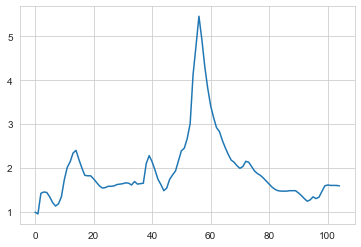

In [5]:
paths_input= '/Volumes/Benitez/buoy_AU/noaa_forecast/noaa_wave_ensemble/ensemble_2021_11_07/'
paths_output= '/Volumes/Benitez/buoy_AU/noaa_forecast/WaEM_boundary/WaEM_boundary_20211203/'
forecast_time ='20211203'
tpar_boundary_noaa_forecast_AU(True, paths_input, paths_output, forecast_time)